In [1]:
# per il plot delle tabelle
library(gridExtra)
library(grid)  
# per i plot geografici
library(dplyr) 
library(tmap)
# per caricare file geografici
library(rgdal)
# Per i plot circolari
library(circular)
# Per caricare PNG



Attaching package: ‘dplyr’

The following object is masked from ‘package:gridExtra’:

    combine

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: sp
rgdal: version: 1.4-7, (SVN revision 845)
 Geospatial Data Abstraction Library extensions to R successfully loaded
 Loaded GDAL runtime: GDAL 2.4.2, released 2019/06/28
 Path to GDAL shared files: /Library/Frameworks/R.framework/Versions/3.6/Resources/library/rgdal/gdal
 GDAL binary built with GEOS: FALSE 
 Loaded PROJ.4 runtime: Rel. 5.2.0, September 15th, 2018, [PJ_VERSION: 520]
 Path to PROJ.4 shared files: /Library/Frameworks/R.framework/Versions/3.6/Resources/library/rgdal/proj
 Linking to sp version: 1.3-1 

Attaching package: ‘circular’

The following objects are masked from ‘package:stats’:

    sd, var



Analisi dati Incidenti in Italia
======

In questo progetto abbiamo analizzato statisticamente i dati sugli incidenti in Italia nell'anno 2017. 

Le fonti dei dati sono:
* Microdati dell'**ISTAT** su tutta la popolazione di incidenti in Italia nel 2017.
* Microdati sulle patenti italiane forniti dal **Ministero delle Infrastrutture e dei Trasporti**, riferiti alla data 26/05/2017 
* Dati tabulati dell'**ISTAT** per la popolazione Italiana per regione, 2019.
* Dati tabulati parco veicolare per regione preso dall'**ISTAT** per il 2016.
* **Ministero delle Infrastrutture e dei Trasporti** per i dati tabulati sulla lunghezze delle strade.

Tutta l'analisi parte come base dai dati sugli incidenti e usa le altre fonti per eseguire confronti su popolazione.

Si noti che, per i casi considerati in questa analisi, si identifica come **incidente** un qualsiasi evento che coinvolga almeno un veicolo autostradale e comporti la presenza di almeno un ferito e/o morto.

Al fine di eseguire un'*analisi campionaria*, abbiamo considerato un campione di grandezza `SAMPLE_SIZE`.

------

In [2]:
dataset_proj <- read.csv("dataset/dataset progetto.csv", sep=';')

In [3]:
cat("Grandezza del dataset:",ncol(dataset_proj),"x",nrow(dataset_proj))

Grandezza del dataset: 117 x 174933

Andiamo a prendere un campione di dal dataset che viene fornito. Per modificare la grandezza del campione, si cambi `SAMPLE_SIZE`.

In [4]:
SAMPLE_SIZE = 20000
sample_rows <- sample(nrow(dataset_proj), SAMPLE_SIZE)
sample_data = dataset_proj[sample_rows,]
attach(sample_data)

## Analisi Univariata

**NOTA** Sarebbe interessante confrontare questi dati con quelli del traffico in Italia, e vedere effettivamente come ci sia una correlazione lineare tra numero di auto in strada e numero di incidenti per ora.

### Orari più pericolosi

Analizziamo i dati forniti per individuare quale sia l'orario più pericoloso.

In [5]:
incidenti_per_Ora <- factor(Ora)
levels(incidenti_per_Ora) <- c("00","01","02","03","04","05","06","07","08","09","10","11","12","13","14","15","16","17","18","19","20","21","22","23","NS")

In [6]:
incidenti_per_Ora.freq <- table(incidenti_per_Ora)
incidenti_per_Ora.relfreq <- incidenti_per_Ora.freq/SAMPLE_SIZE
incidenti_per_Ora.percfreq <- incidenti_per_Ora.relfreq*100

In [7]:
# make our data into circular class from package circular
ora_circolare <- circular(Ora, # convert to 24 hrs
      units="hours", template="clock24")

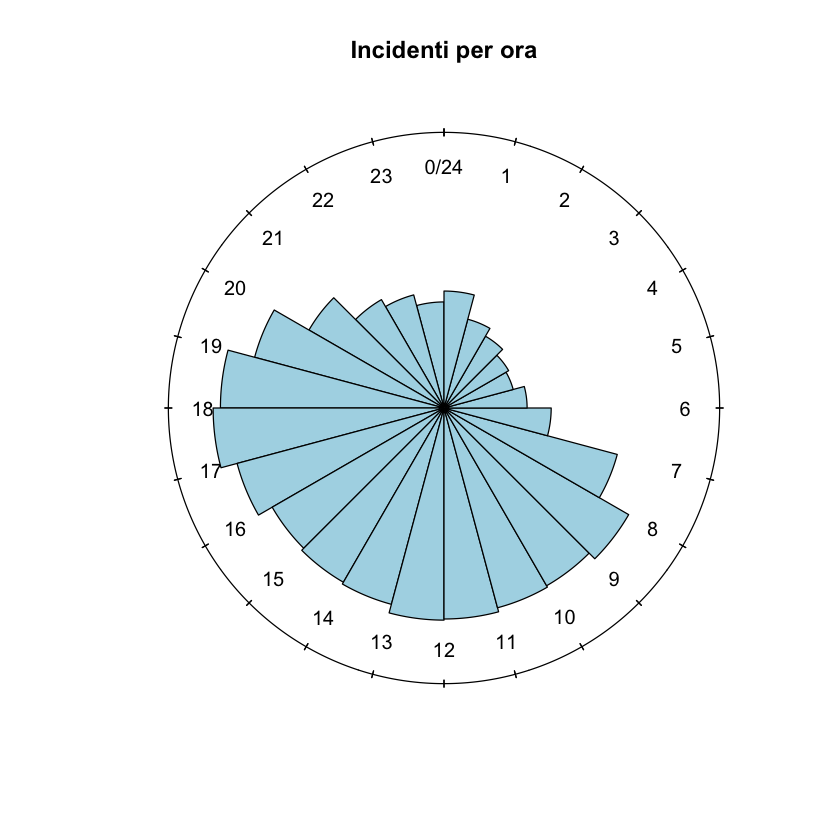

In [8]:
# plot a rose diagram, setting prop(ortion) argument after trial-n-error
rose.diag(ora_circolare, bin = 24, col = "lightblue", main = "Incidenti per ora", 
    prop = 3)

Le freq. ASSOLUTE sono:  353 247 201 163 150 202 336 941 1330 1232 1251 1302 1316 1208 1184 1151 1342 1559 1462 1124 711 458 401 329 47 

Le freq. RELATIVE sono:  0.01765 0.01235 0.01005 0.00815 0.0075 0.0101 0.0168 0.04705 0.0665 0.0616 0.06255 0.0651 0.0658 0.0604 0.0592 0.05755 0.0671 0.07795 0.0731 0.0562 0.03555 0.0229 0.02005 0.01645 0.00235 

Le freq. PERCENTUALI sono:  1.765 1.235 1.005 0.815 0.75 1.01 1.68 4.705 6.65 6.16 6.255 6.51 6.58 6.04 5.92 5.755 6.71 7.795 7.31 5.62 3.555 2.29 2.005 1.645 0.235

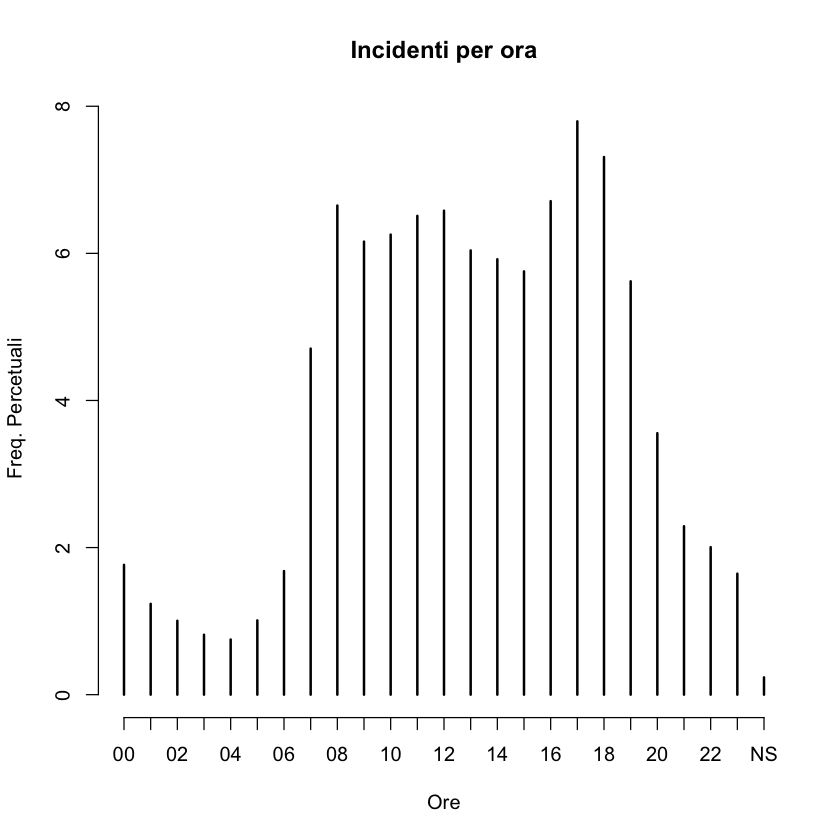

In [9]:
cat("Le freq. ASSOLUTE sono: ",incidenti_per_Ora.freq,"\n\n")
cat("Le freq. RELATIVE sono: ",incidenti_per_Ora.relfreq,"\n\n")
cat("Le freq. PERCENTUALI sono: ",incidenti_per_Ora.percfreq)
#drop della colonna in cui non è stata specificata l'ora
#incidenti_per_Ora.freq <- incidenti_per_Ora.freq[-c(25)] 
plot(incidenti_per_Ora.percfreq,xlab = "Ore",ylab = "Freq. Percetuali", main='Incidenti per ora', type='h')

In [10]:
pdf("results/incidenti_per_ora.pdf")
plot(incidenti_per_Ora.percfreq,xlab = "Ore",ylab = "Freq. Percetuali", main='Incidenti per ora')
dev.off()

pdf 
  2

In [11]:
moda_incidenti_per_Ora <- which(incidenti_per_Ora.percfreq==max(incidenti_per_Ora.percfreq))
cat("L'orario con più incidenti è quello delle: ", names(moda_incidenti_per_Ora))

L'orario con più incidenti è quello delle:  17

Da questa analisi, si nota come la concentrazione degli incidenti, come ci si potrebbe aspettare, coincide con le ore di punta. In particolare, gli orari 17 e 18 risultano quelli con più incidenti nel corso della giornata. 

L'ora in assoluto che presenta più incidenti è quella delle 18.

### Incidenti città metropolitane

Ci siamo proposti di analizzare quale tra le 5 maggiori province con aree metropolitane, ovvero Torino, Roma, Milano, Genova e Napoli, abbia un maggior numero di incidenti. In particolare, andiamo a calcolare l'eterogeneità (o meno) di queste misure.

In [8]:
incidenti_per_provincia <- factor(provincia)
incidenti_per_provincia <- table(incidenti_per_provincia)

In [9]:
#1:torino,10:Genova,15:Milano,58:Roma,63:Napoli
incidenti_per_provinciaRidotta <- incidenti_per_provincia[c(1,10,15,58,63)]
#NON SO PER QUALE MOTIVO NON RIESCO AD USARE LEVELS PER SETTARE IL NOME DELLE COLONNE...
names(incidenti_per_provinciaRidotta)[c(1,2,3,4,5)]<-c("TORINO","GENOVA","MILANO","ROMA","NAPOLI")
incidenti_per_provinciaRidotta

TORINO GENOVA MILANO   ROMA NAPOLI 
   659    622   1603   1861    570 

In [ ]:
incidenti_per_provinciaR.freq <- incidenti_per_provinciaRidotta
incidenti_per_provinciaR.relfreq <- incidenti_per_provinciaRidotta/SAMPLE_SIZE
incidenti_per_provinciaR.percfreq <- incidenti_per_provinciaR.relfreq*100
incidenti_per_provinciaR.percfreq

TORINO GENOVA MILANO   ROMA NAPOLI 
 3.250  3.050  8.325  9.320  2.925 

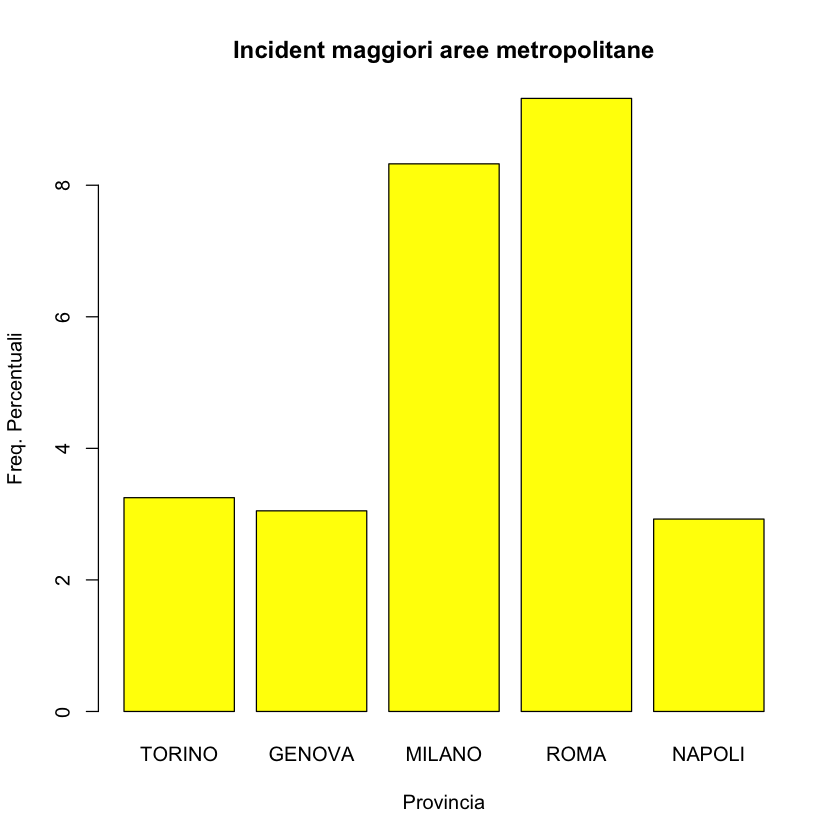

In [14]:
barplot(incidenti_per_provinciaR.percfreq,col = "yellow",xlab = "Provincia",ylab = "Freq. Percentuali",
       main="Incident maggiori aree metropolitane")

In [15]:
pdf("results/incidenti_maggiori_aree_metropolitane.pdf")
barplot(incidenti_per_provinciaR.percfreq,col = "yellow",xlab = "Provincia",ylab = "Freq. Percentuali",
       main="Incident maggiori aree metropolitane")
dev.off()

pdf 
  2

In [16]:
#CALCOLO COSE "RIDONDATI" PER AVER MATERIALE DA METTERE NELLA RELAZIONE
moda_incidenti_per_provinciaR <- which(incidenti_per_provinciaR.percfreq==max(incidenti_per_provinciaR.percfreq))
cat("La provincia tra quelle mostrate con più incidenti è quella di ",names(moda_incidenti_per_provinciaR))

La provincia tra quelle mostrate con più incidenti è quella di  ROMA

In [17]:
indice_eterogeneitaGiniNorm <- function(freqRel,k){
    x=0
    for(i in freqRel){
        x=x+i^2
    }
    z = (1-x)*(k)/(k-1)
    z
}

In [18]:
incidenti_per_provincia.relfreq <- incidenti_per_provincia/SAMPLE_SIZE
x=0
#length(incidenti_per_provincia.relfreq)==length(incidenti_per_provincia)
Gnorm <- indice_eterogeneitaGiniNorm(incidenti_per_provincia.relfreq,length(incidenti_per_provincia))
cat("Gnorm = ",Gnorm," un valore vicino alla massima eterogeneità")

Gnorm =  0.9827208  un valore vicino alla massima eterogeneità

Una prima analisi, senza considerazione di popolazione, mostra come la città con il maggior numero di incidenti sia **Roma**. Di seguito viene mostrata la stessa analisi, ma pesata sul numero di abitanti.

In [19]:
#Mantengo lo stesso ordine presente nella tabella con le frequenze.
popolazione_maggiori_province = c(2259523,841180,3250315, 4342212, 3084890)

In [20]:
incidenti_per_provinciaR.per_abitante = array(0,5)
for(i in 1:length(incidenti_per_provinciaR.relfreq))
{
        incidenti_per_provinciaR.per_abitante[i] =  100000 * incidenti_per_provinciaR.relfreq[i] * nrow(dataset_proj) / popolazione_maggiori_province[i]
}
#incidenti_per_provinciaR.per_abitante = table(incidenti_per_provinciaR.per_abitante)
names(incidenti_per_provinciaR.per_abitante) = c("TORINO","GENOVA","MILANO","ROMA","NAPOLI")

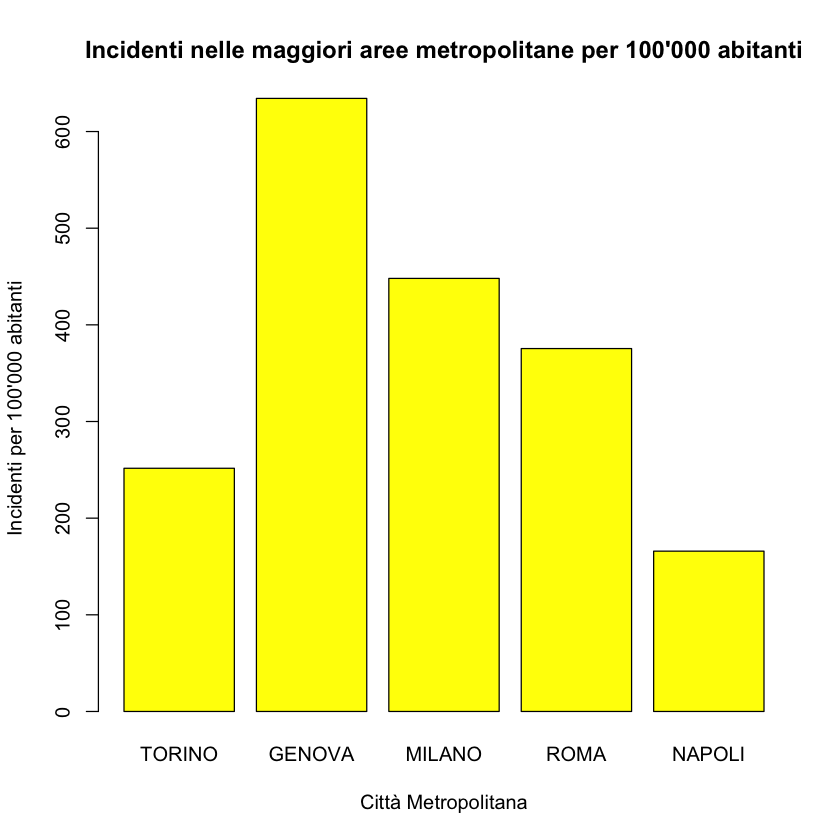

In [21]:
barplot(incidenti_per_provinciaR.per_abitante,col = "yellow",xlab = "Città Metropolitana",ylab = "Incidenti per 100'000 abitanti", main="Incidenti nelle maggiori aree metropolitane per 100'000 abitanti")

In [22]:
pdf("results/incidenti_per_abitante_aree_metropolinate.pdf")
barplot(incidenti_per_provinciaR.per_abitante,col = "yellow",xlab = "Città Metropolitana",ylab = "Incidenti per 100'000 abitanti", main="Incidenti nelle maggiori aree metropolitane per 100'000 abitanti")
dev.off()

pdf 
  2

In [23]:
cat("La provincia tra quelle mostrate con più incidenti per 100'000 abitanti è quella di ",names(which(incidenti_per_provinciaR.per_abitante==max(incidenti_per_provinciaR.per_abitante))))

La provincia tra quelle mostrate con più incidenti per 100'000 abitanti è quella di  GENOVA

In [24]:
total_fre_per_abitante = sum(incidenti_per_provinciaR.per_abitante)

In [25]:
x=0
Gnorm <- indice_eterogeneitaGiniNorm(incidenti_per_provinciaR.per_abitante/total_fre_per_abitante,5)
cat("Gnorm = ",Gnorm," un valore vicino alla massima eterogeneità")

Gnorm =  0.95325  un valore vicino alla massima eterogeneità

Da questa analisi si mostra come, sebbene Roma sia la città metropolitana che presenta in totale il maggior numero di incidenti, è Genova la città che, per numero di abitanti, ha più incidenti. In particolare, tra quelle analizzate, Napoli è la città col minor numero di incidenti, sia in assoluto che sugli abitanti.

### Analisi autostradale

Analizziamo gli incidenti nei tratti autostradali, che essi siano denominati con la lettera `A` (autostrada), `R` (raccordo) o `T` (tronco). Purtroppo, per difficoltà di reperibilità, non siamo riusciti a paragonare con la lunghezza dell'autostrada e/o il traffico. Questo fa sì che questa piccola analisi non mostri l'autostrada più pericolosa su cui guidare, ma semplicemente quella in cui sono presenti più incidenti.

In [26]:
new_localizzazione_incidente = array(10, length(localizzazione_incidente))

In [27]:
for(i in 1:length(localizzazione_incidente))
{

    if(localizzazione_incidente[i] == 0 || localizzazione_incidente[i] == 1 || localizzazione_incidente[i] == 2 || localizzazione_incidente[i] == 3)    
    {
        new_localizzazione_incidente[i] = 0

    }
    if(localizzazione_incidente[i] == 4 || localizzazione_incidente[i] == 5 || localizzazione_incidente[i] == 6 || localizzazione_incidente[i] == 9)    
    {
        new_localizzazione_incidente[i] = 1
    }
    if(localizzazione_incidente[i] == 7)
    {
        new_localizzazione_incidente[i] = 2
    }
    
}

In [28]:
new_localizzazione_incidente <- factor(new_localizzazione_incidente)
levels(new_localizzazione_incidente) <- c("urbana", "extraurbana", "autostrada", "altro")

In [29]:
incidenti_in_autostrada = sample_data[which(new_localizzazione_incidente=="autostrada"),]

In [30]:
tabella_incidenti_in_autostrada = table(droplevels(incidenti_in_autostrada$denominazione_della_strada))

In [31]:
tabella_incidenti_in_autostrada.percfeq = tabella_incidenti_in_autostrada/nrow(incidenti_in_autostrada)*100

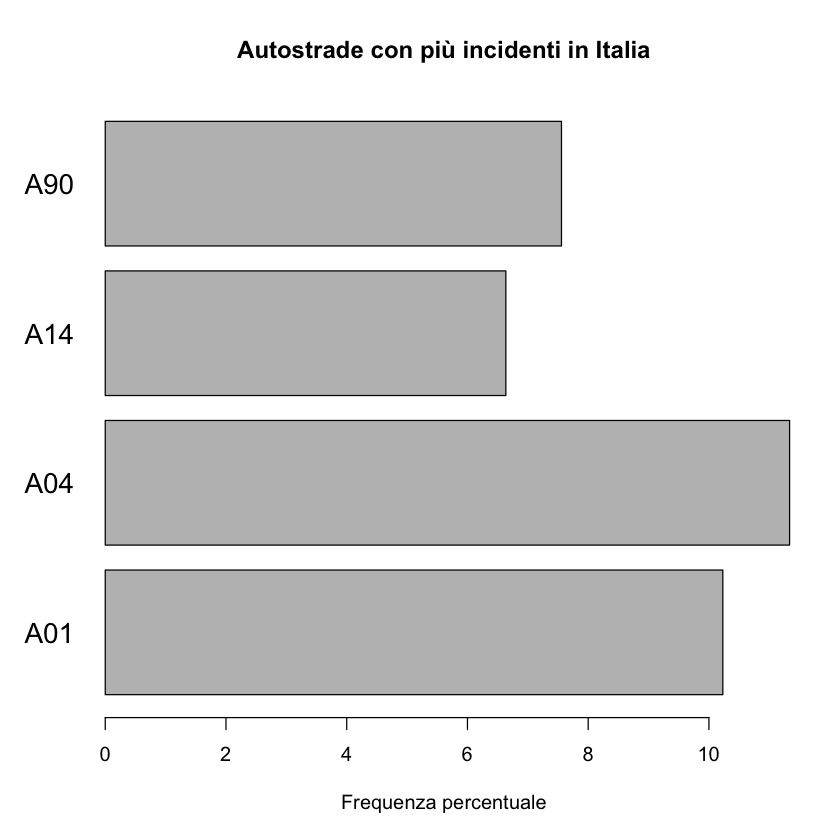

In [32]:
barplot(tabella_incidenti_in_autostrada.percfeq[which(tabella_incidenti_in_autostrada.percfeq > 5)], 
        xlab='Frequenza percentuale', 
        #ylab='Denominazione autostrada', 
        main='Autostrade con più incidenti in Italia',
       horiz=TRUE,
        las=1, #per mettere le scritte sull'asse y in orizzontale
       cex.names=1.4)

In [33]:
pdf("results/maggiori_autostrade.pdf")
barplot(tabella_incidenti_in_autostrada.percfeq[which(tabella_incidenti_in_autostrada.percfeq > 5)], 
        xlab='Frequenza percentuale', 
        #ylab='Denominazione autostrada', 
        main='Autostrade con più incidenti in Italia',
       horiz=TRUE,
        las=1, #per mettere le scritte sull'asse y in orizzontale
       cex.names=1.4)
dev.off()

pdf 
  2

In [34]:
tabella_incidenti_in_autostrada.percfreq = tabella_incidenti_in_autostrada/nrow(incidenti_in_autostrada)*100
tabella_incidenti_in_autostrada.mode = which(tabella_incidenti_in_autostrada.percfreq==max(tabella_incidenti_in_autostrada.percfreq))

In [35]:
cat("L'autostrada con più incidenti in Italia nel 2017 è la", names(tabella_incidenti_in_autostrada.mode))

L'autostrada con più incidenti in Italia nel 2017 è la A04

L'autostrada che presenta più incidenti in Italia è la A4, nota anche come **Milano-Venezia**. Purtroppo non siamo riusciti a ottenere i dati per il traffico sulle diverse autostrade, e quindi rimane limitata nei suoi obiettivi: non siamo in grado di concludere quale sia la più pericosola. 

Rimane comunque il fatto che, qualora una persona decidesse di mettersi alla guida, essere a conoscenza del tratto autostradale con più incidenti in Italia può risultare un'informazione abbastanza utile.

------

### Incidenti con un solo veicolo

Siamo andati ad analizzare la distribuzione dei sessi negli incidenti in cui è coinvolto un solo veicolo. Ovvero ci siamo posti l'obiettivo di rispondere alla domanda _<<chi tra uomini e donne tende a commettere più incidenti da solo?>>_.

Sebbene questa analisi non rimandi con precisione quale tra i due sessi sia effettivamente più pericoloso, mostra comunque quale tra i due tenda a commettere più incidenti da solo.

In [36]:
# Sostituisco i NaN con 666. Non è bellissimo, ma rende possibile sepapare.
tipo_veicoli__b_[is.na(tipo_veicoli__b_)] <- 666

tipo_veicoli__b_[is.na(tipo_veicoli__b_)] <- 666
schianto_da_soli = dataset_proj[which(tipo_veicoli__b_ == 666),]

cat("Sul totale degli incidenti, la percentuale di quelli in cui è coinvolto solamente un veicolo è il", 
    as.integer(nrow(schianto_da_soli)/SAMPLE_SIZE*10000)/100,"%")

Sul totale degli incidenti, la percentuale di quelli in cui è coinvolto solamente un veicolo è il 27.9 %

In [37]:
# Sostituisco i Nan con dei 3
schianto_da_soli$veicolo__a___sesso_conducente[is.na(schianto_da_soli$veicolo__a___sesso_conducente)] <- 3
schianto_da_soli$veicolo__a___sesso_conducente <- factor(schianto_da_soli$veicolo__a___sesso_conducente)
# Cambio i nomi in Maschio, Femmina e Sconosciuto (ovvero dove vi era un NaN)
levels(schianto_da_soli$veicolo__a___sesso_conducente) <- c("Maschio", "Femmina","Sconosciuto")
# Creo una tabella per i sessi
tabella_schianto_da_soli_sesso = table(schianto_da_soli$veicolo__a___sesso_conducente)
# Calcolo frequenze relative e percentuali
tabella_schianto_da_soli_sesso.relfreq <- tabella_schianto_da_soli_sesso/length(schianto_da_soli$veicolo__a___sesso_conducente)
tabella_schianto_da_soli_sesso.percfreq <- tabella_schianto_da_soli_sesso.relfreq*100

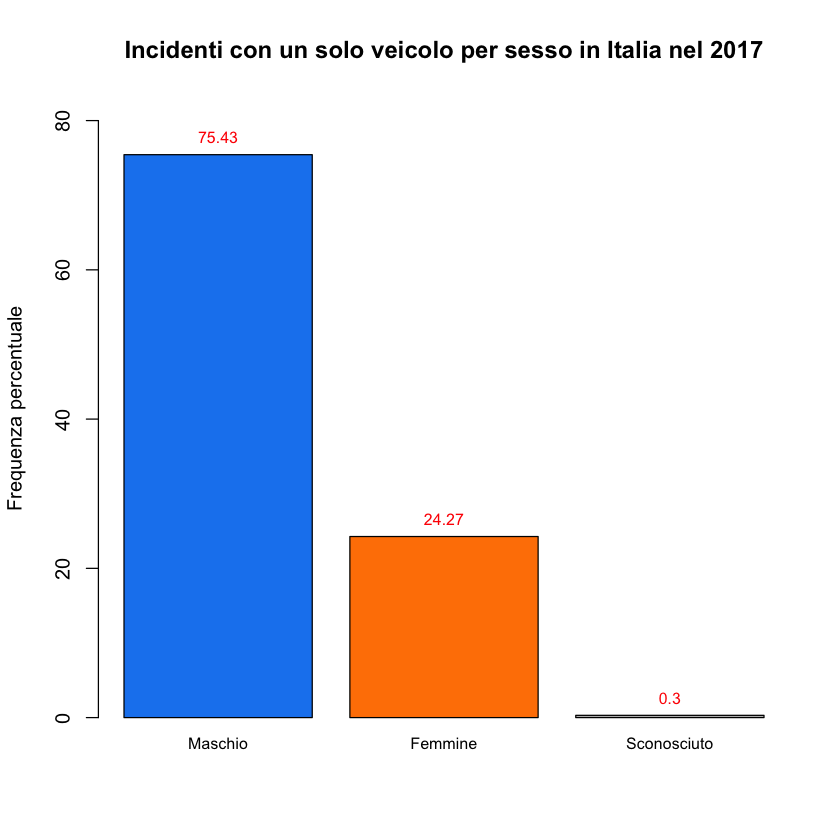

In [106]:
# Faccio grafico a barre
ylim <- c(0, 1.1*max(tabella_schianto_da_soli_sesso.percfreq))
xx <- barplot(tabella_schianto_da_soli_sesso.percfreq, xaxt = 'n', xlab = '', width = 0.85, ylim = ylim,
              main = "Incidenti con un solo veicolo per sesso in Italia nel 2017", 
              ylab = "Frequenza percentuale",
             col=c('#1a86ef', '#ff8100', 'grey'))
text(x = xx, y = tabella_schianto_da_soli_sesso.percfreq,
     label = as.integer(tabella_schianto_da_soli_sesso.percfreq*100+0.5)/100,
     pos = 3, cex = 0.8, col = "red")
axis(1, at=xx, labels=c("Maschio", "Femmine", "Sconosciuto"), tick=FALSE, las=1, line=-0.5, cex.axis=0.8)

In [39]:
pdf("results/incidenti_per_sesso.pdf")
# Faccio grafico a barre
ylim <- c(0, 1.1*max(tabella_schianto_da_soli_sesso.percfreq))
xx <- barplot(tabella_schianto_da_soli_sesso.percfreq, xaxt = 'n', xlab = '', width = 0.85, ylim = ylim,
              main = "Incidenti con un solo veicolo per sesso in Italia nel 2017", 
              ylab = "Frequenza percentuale",
             col=c('#1a86ef', '#ff8100', 'grey'))
text(x = xx, y = tabella_schianto_da_soli_sesso.percfreq,
     label = as.integer(tabella_schianto_da_soli_sesso.percfreq*100+0.5)/100,
     pos = 3, cex = 0.8, col = "red")
axis(1, at=xx, labels=c("Maschio", "Femmine", "Sconosciuto"), tick=FALSE, las=1, line=-0.5, cex.axis=0.8)
dev.off()

pdf 
  2

Questo grafico è molto significativo, e mostra come vi siano molti più uomini che fanno incidenti da soli rispetto alle donne. Non tiene però conto del fatto che vi siano più uomini che donne alla guida.

Abbiamo quindi eseguito un'analisi più dettagliata, nella quale siamo andati a considerare anche la percentuale di patenti in Italia per i rispettivi sessi. Come indicato all'inizio, siamo andati a prendere i **microdati** relativi alle patenti fornite dal **Ministero delle Infrastrutture e dei Trasporti** per il 2017.

In [40]:
# Di seguito si vanno ad aprire tutti i file per le patenti. Purtroppo sono divisi per regione. 
# La mole di dati è molto grande, quindi richiede una grossa quantità di tempo per riuscire ad 
# elaborarli tutti.

In [41]:
patenti_Abruzzo <- read.csv("dataset/informazioni_patenti_per_regione/patenti_Abruzzo.csv", sep=',')

In [42]:
patenti_Basilicata <- read.csv("dataset/informazioni_patenti_per_regione/patenti_Basilicata.csv", sep=',')

In [43]:
patenti_Calabria <- read.csv("dataset/informazioni_patenti_per_regione/patenti_Calabria.csv", sep=',')

In [44]:
patenti_Campania <- read.csv("dataset/informazioni_patenti_per_regione/patenti_Campania.csv", sep=',')

In [45]:
patenti_EmiliaRomagna <- read.csv("dataset/informazioni_patenti_per_regione/patenti_EmiliaRomagna.csv", sep=',')

In [46]:
patenti_FriuliVeneziaGiulia <- read.csv("dataset/informazioni_patenti_per_regione/patenti_FriuliVeneziaGiulia.csv", sep=',')

In [47]:
patenti_Lazio <- read.csv("dataset/informazioni_patenti_per_regione/patenti_Lazio.csv", sep=',')

In [48]:
patenti_Liguria <- read.csv("dataset/informazioni_patenti_per_regione/patenti_Liguria.csv", sep=',')

In [49]:
patenti_Liguria <- read.csv("dataset/informazioni_patenti_per_regione/patenti_Liguria.csv", sep=',')

In [50]:
patenti_Lombardia <- read.csv("dataset/informazioni_patenti_per_regione/patenti_Lombardia.csv", sep=',')

In [51]:
patenti_Marche <- read.csv("dataset/informazioni_patenti_per_regione/patenti_Marche.csv", sep=',')

In [52]:
patenti_Molise <- read.csv("dataset/informazioni_patenti_per_regione/patenti_Molise.csv", sep=',')

In [53]:
patenti_Piemonte <- read.csv("dataset/informazioni_patenti_per_regione/patenti_Piemonte.csv", sep=',')

In [54]:
patenti_Puglia <- read.csv("dataset/informazioni_patenti_per_regione/patenti_Puglia.csv", sep=',') 

In [55]:
patenti_Sardegna <- read.csv("dataset/informazioni_patenti_per_regione/patenti_Sardegna.csv", sep=',') 

In [56]:
patenti_Sicilia <- read.csv("dataset/informazioni_patenti_per_regione/patenti_Sicilia.csv", sep=',') 

In [57]:
patenti_Toscana <- read.csv("dataset/informazioni_patenti_per_regione/patenti_Toscana.csv", sep=',') 

In [58]:
patenti_TrentinoAltoAdige <- read.csv("dataset/informazioni_patenti_per_regione/patenti_TrentinoAltoAdige.csv", sep=',') 

In [59]:
patenti_Umbria <- read.csv("dataset/informazioni_patenti_per_regione/patenti_Umbria.csv", sep=',') 

In [60]:
patenti_ValleAosta <- read.csv("dataset/informazioni_patenti_per_regione/patenti_ValleAosta.csv", sep=',') 

In [61]:
patenti_Veneto <- read.csv("dataset/informazioni_patenti_per_regione/patenti_Veneto.csv", sep=',') 

In [62]:
# Si contano quante patenti sono identificate come "M" e quante come "F"
patenti_femmine = length(which(patenti_Abruzzo$sesso=="F")) + length(which(patenti_Basilicata$sesso=="F")) + length(which(patenti_Calabria$sesso=="F")) + length(which(patenti_Campania$sesso=="F")) + length(which(patenti_EmiliaRomagna$sesso=="F")) + length(which(patenti_FriuliVeneziaGiulia$sesso=="F")) + length(which(patenti_Lazio$sesso=="F")) + length(which(patenti_Liguria$sesso=="F")) + length(which(patenti_Lombardia$sesso=="F")) + length(which(patenti_Marche$sesso=="F")) + length(which(patenti_Molise$sesso=="F")) + length(which(patenti_Piemonte$sesso=="F")) + length(which(patenti_Puglia$sesso=="F")) + length(which(patenti_Sardegna$sesso=="F")) + length(which(patenti_Sicilia$sesso=="F")) + length(which(patenti_Toscana$sesso=="F")) + length(which(patenti_TrentinoAltoAdige$sesso=="F")) + length(which(patenti_Umbria$sesso=="F")) + length(which(patenti_ValleAosta$sesso=="F")) + length(which(patenti_Veneto$sesso=="F"))
patenti_maschi = length(which(patenti_Abruzzo$sesso=="M")) + length(which(patenti_Basilicata$sesso=="M")) + length(which(patenti_Calabria$sesso=="M")) + length(which(patenti_Campania$sesso=="M")) + length(which(patenti_EmiliaRomagna$sesso=="M")) + length(which(patenti_FriuliVeneziaGiulia$sesso=="M")) + length(which(patenti_Lazio$sesso=="M")) + length(which(patenti_Liguria$sesso=="M")) + length(which(patenti_Lombardia$sesso=="M")) + length(which(patenti_Marche$sesso=="M")) + length(which(patenti_Molise$sesso=="M")) + length(which(patenti_Piemonte$sesso=="M")) + length(which(patenti_Puglia$sesso=="M")) + length(which(patenti_Sardegna$sesso=="M")) + length(which(patenti_Sicilia$sesso=="M")) + length(which(patenti_Toscana$sesso=="M")) + length(which(patenti_TrentinoAltoAdige$sesso=="M")) + length(which(patenti_Umbria$sesso=="M")) + length(which(patenti_ValleAosta$sesso=="M")) + length(which(patenti_Veneto$sesso=="M"))
# Si uniscono le frequenza assolute in una tabella, a cui vengono dati poi dei nomi alle righe
tabella_patenti = as.table(c(patenti_maschi,patenti_femmine))
rownames(tabella_patenti) = c("Maschi", "Femmine")

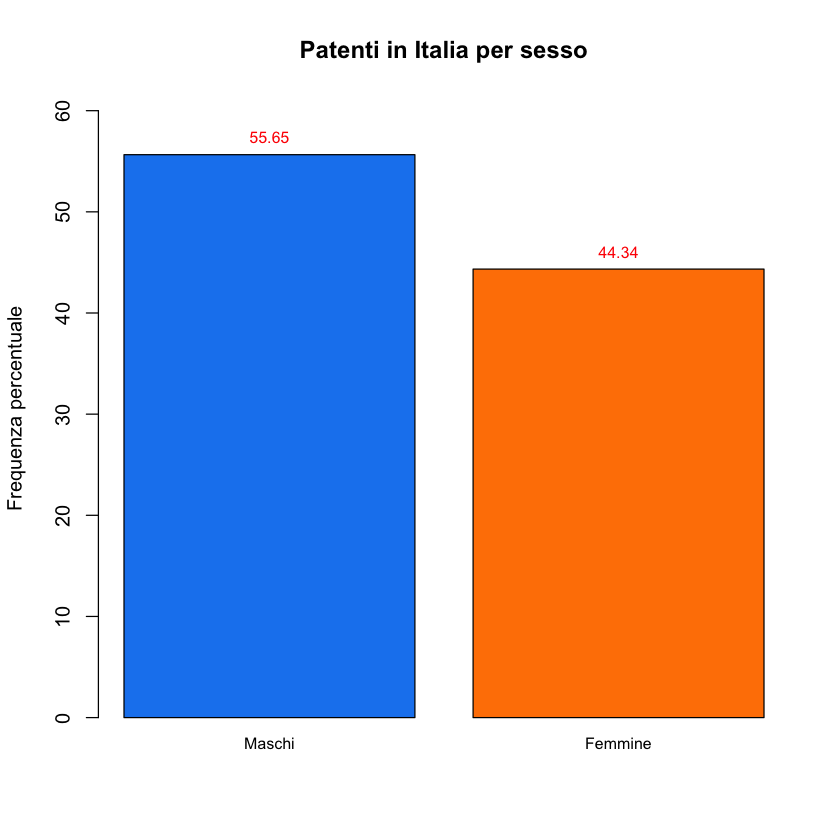

In [63]:
# Grafico della frequenza percentuale dei due sessi per il numero di patenti
tabella_patenti.percfreq <- as.numeric(as.character(as.integer(tabella_patenti/(tabella_patenti[1]+tabella_patenti[2])*10000)/100))
ylim <- c(0, 1.1*max(tabella_patenti.percfreq))
xx <- barplot(tabella_patenti.percfreq, xaxt = 'n', xlab = '', width = 0.85, ylim = ylim,
              main = "Patenti in Italia per sesso", 
              ylab = "Frequenza percentuale",
             col=c('#1a86ef','#ff8100'))
text(x = xx, y = tabella_patenti.percfreq,
     label = tabella_patenti.percfreq,
     pos = 3, cex = 0.8, col = "red")
axis(1, at=xx, labels=c("Maschi", "Femmine"), tick=FALSE, las=1, line=-0.5, cex.axis=0.8)

In [64]:
pdf("results/patenti_per_sesso.pdf")
# Grafico della frequenza percentuale dei due sessi per il numero di patenti
tabella_patenti.percfreq <- as.numeric(as.character(as.integer(tabella_patenti/(tabella_patenti[1]+tabella_patenti[2])*10000)/100))
ylim <- c(0, 1.1*max(tabella_patenti.percfreq))
xx <- barplot(tabella_patenti.percfreq, xaxt = 'n', xlab = '', width = 0.85, ylim = ylim,
              main = "Patenti in Italia per sesso", 
              ylab = "Frequenza percentuale",
             col=c('#1a86ef','#ff8100'))
text(x = xx, y = tabella_patenti.percfreq,
     label = tabella_patenti.percfreq,
     pos = 3, cex = 0.8, col = "red")
axis(1, at=xx, labels=c("Maschi", "Femmine"), tick=FALSE, las=1, line=-0.5, cex.axis=0.8)
dev.off()

pdf 
  2

Vado quindi a dividere il numero di incidenti dei due sessi per il rispettivo numero di patenti, ovvero ottengo la distribuzione degli **incidenti per numero di patenti** per entrambi i sessi.

In [124]:
# La percentuale di incidenti con un solo veicolo coinvolto. Stimato dal campione
prob_schianti_da_soli = nrow(schianto_da_soli)/SAMPLE_SIZE
# Il numero totale di incidenti con un solo veicolo coinvolto. Stimato dal campione.
numero_schianti_da_soli = prob_schianti_da_soli * nrow(dataset_proj)

In [127]:

tabella_schianti_per_patenti = array(0, length(tabella_patenti))
for(i in 1:nrow(tabella_patenti))
    {
        # Moltiplico la frequenza relativa dei due sessi per il numero totale di incidenti
        # e divido per il numero di patenti del suddetto sesso.
        tabella_schianti_per_patenti[i] = 100000*tabella_schianto_da_soli_sesso.relfreq[i] * numero_schianti_da_soli / tabella_patenti[i]
    }

Io non posso dedurre da questi dati la *probabilità che un maschio commetta un incidente da solo* (e viceversa); però posso mostrare quanto sia più probabile che un maschio commetta un incidente da solo rispetto a una femmina.

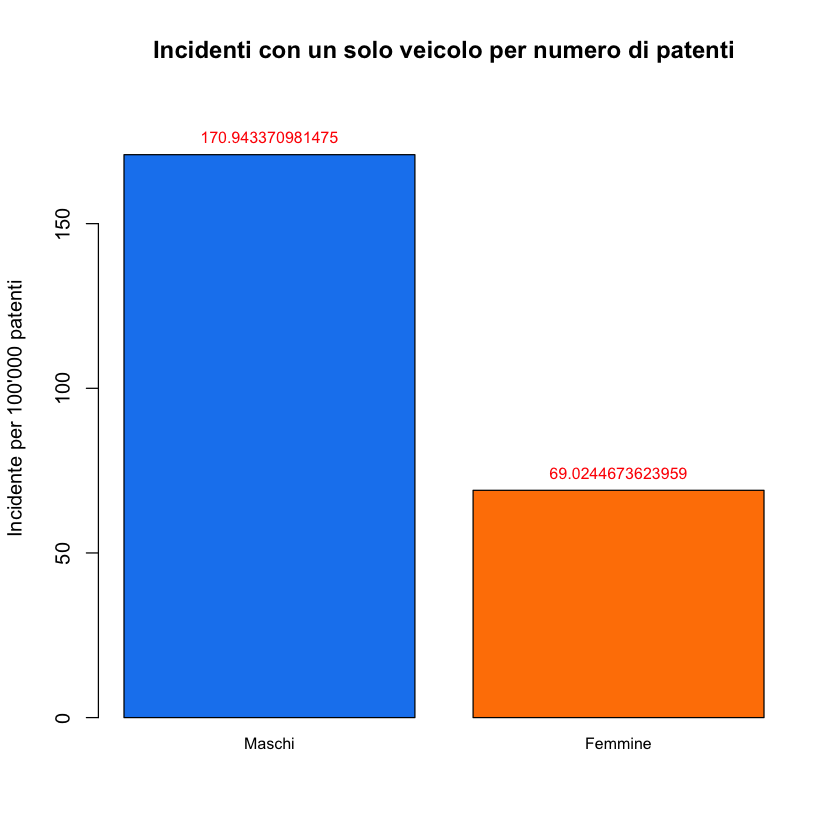

In [128]:
tabella_schianti_per_patenti <- as.numeric(as.character((tabella_schianti_per_patenti)))
names(tabella_schianti_per_patenti) = c("Maschi", "Femmine")
ylim <- c(0, 1.1*max(as.numeric(tabella_schianti_per_patenti)))
xx <- barplot(tabella_schianti_per_patenti, xaxt = 'n', xlab = '', width = 0.85, ylim = ylim,
              main = "Incidenti con un solo veicolo per numero di patenti", 
              ylab = "Incidente per 100'000 patenti",
             col=c('#1a86ef','#ff8100'))
text(x = xx, y = tabella_schianti_per_patenti,
     label = tabella_schianti_per_patenti,
     pos = 3, cex = 0.8, col = "red")
axis(1, at=xx, labels=c("Maschi", "Femmine"), tick=FALSE, las=1, line=-0.5, cex.axis=0.8)

In [129]:
pdf("results/incidenti_per_sesso_per_patenti.pdf")
tabella_schianti_per_patenti <- as.numeric(as.character((tabella_schianti_per_patenti)))
names(tabella_schianti_per_patenti) = c("Maschi", "Femmine")
ylim <- c(0, 1.1*max(as.numeric(tabella_schianti_per_patenti)))
xx <- barplot(tabella_schianti_per_patenti, xaxt = 'n', xlab = '', width = 0.85, ylim = ylim,
              main = "Incidenti con un solo veicolo per numero di patenti", 
              ylab = "Incidente per 100'000 patenti",
             col=c('#1a86ef','#ff8100'))
text(x = xx, y = tabella_schianti_per_patenti,
     label = tabella_schianti_per_patenti,
     pos = 3, cex = 0.8, col = "red")
axis(1, at=xx, labels=c("Maschi", "Femmine"), tick=FALSE, las=1, line=-0.5, cex.axis=0.8)
dev.off()

pdf 
  2

In [130]:
cat("I maschi è il",as.integer(10000*(tabella_schianti_per_patenti[1]-tabella_schianti_per_patenti[2])/tabella_schianti_per_patenti[2])/100,
    "% più probabile di causare un incidente con un solo veicolo coinvolto.")

I maschi è il 147.65 % più probabile di causare un incidente con un solo veicolo coinvolto.

Ho trovato che è quasi 1.5 volte più probabile che un uomo causi un incidente rispetto a una donna.

### Incidenti nelle regioni

In [69]:
incidenti_per_provincia <- provincia
tabella_incidenti_per_provincia <- table(incidenti_per_provincia)

In [70]:
# Se non metto un valore numerico, va tutto a quel paese
incidenti_per_regione = array(666, length(incidenti_per_provincia))

In [71]:
for(i in 1:SAMPLE_SIZE)
{

    if(incidenti_per_provincia[i] > 0 & incidenti_per_provincia[i] < 7 | incidenti_per_provincia[i] == 96 | incidenti_per_provincia[i] == 103)
    {
        incidenti_per_regione[i] = 1


    }

     if(incidenti_per_provincia[i] == 7)
    {
        incidenti_per_regione[i] = 2

    }
    

     if(incidenti_per_provincia[i] > 7 & incidenti_per_provincia[i] < 12)
    {
        incidenti_per_regione[i] = 7

    }    


     if(incidenti_per_provincia[i] > 11 & incidenti_per_provincia[i] < 21 | incidenti_per_provincia[i] == 97 | incidenti_per_provincia[i] == 98 | incidenti_per_provincia[i] == 108)
    {
        incidenti_per_regione[i] = 3

    }    
    

     if(incidenti_per_provincia[i] == 21 | incidenti_per_provincia[i] == 22)
    {
        incidenti_per_regione[i] = 4

    }    
    

     if(incidenti_per_provincia[i] > 22 & incidenti_per_provincia[i] < 30)
    {
        incidenti_per_regione[i] = 5

    }    
    

     if(incidenti_per_provincia[i] > 29 & incidenti_per_provincia[i] < 33 | incidenti_per_provincia[i] == 93)
    {
        incidenti_per_regione[i] = 6

    }    
    

     if(incidenti_per_provincia[i] > 32 & incidenti_per_provincia[i] < 41 | incidenti_per_provincia[i] == 99)
    {
        incidenti_per_regione[i] = 8

    }    
    

     if(incidenti_per_provincia[i] > 40 & incidenti_per_provincia[i] < 45 | incidenti_per_provincia[i] == 109)
    {
        incidenti_per_regione[i] = 11

    }
    

     if(incidenti_per_provincia[i] > 44 & incidenti_per_provincia[i] < 54 | incidenti_per_provincia[i] == 100)
    {
        incidenti_per_regione[i] = 9

    }    


     if(incidenti_per_provincia[i] ==54 | incidenti_per_provincia[i] == 55)
    {
        incidenti_per_regione[i] = 10

    }    
    

     if(incidenti_per_provincia[i] > 55 & incidenti_per_provincia[i] < 61)
    {
        incidenti_per_regione[i] = 12

    }    
    

     if(incidenti_per_provincia[i] > 60 & incidenti_per_provincia[i] < 66)
    {
        incidenti_per_regione[i] = 15

    }    
    

     if(incidenti_per_provincia[i] > 65 & incidenti_per_provincia[i] < 70)
    {
        incidenti_per_regione[i] = 13

    }    
    

     if(incidenti_per_provincia[i] == 70 | incidenti_per_provincia[i] == 94)
    {
        incidenti_per_regione[i] = 14

    }    
    

     if(incidenti_per_provincia[i] > 70 & incidenti_per_provincia[i] < 76 | incidenti_per_provincia[i] == 110)
    {
        incidenti_per_regione[i] = 16

    }
    

     if(incidenti_per_provincia[i] == 76 | incidenti_per_provincia[i] == 77)
    {
        incidenti_per_regione[i] = 17

    }    
    

     if(incidenti_per_provincia[i] > 77 & incidenti_per_provincia[i] < 81 | incidenti_per_provincia[i] == 101 | incidenti_per_provincia[i] == 102)
    {
        incidenti_per_regione[i] = 18

    }    
    

     if(incidenti_per_provincia[i] > 80 & incidenti_per_provincia[i] < 90)
    {
        incidenti_per_regione[i] = 19

    }    
    

     if(incidenti_per_provincia[i] > 89 & incidenti_per_provincia[i] < 93 | incidenti_per_provincia[i] == 95 | incidenti_per_provincia[i] == 111)
    {
        incidenti_per_regione[i] = 20

    }    
    
}

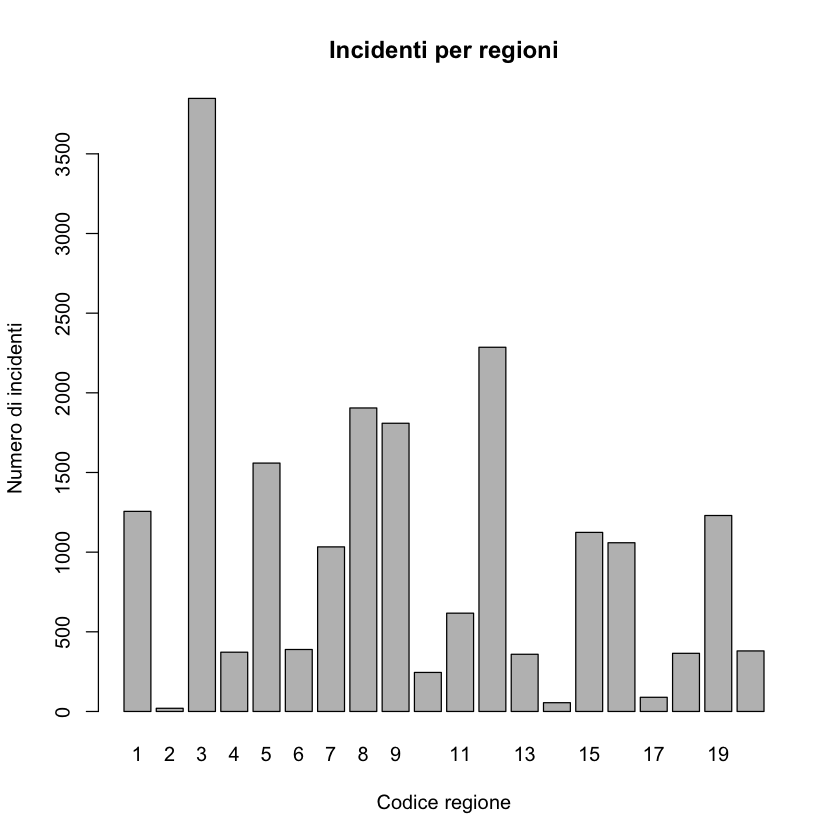

In [72]:
barplot(table(incidenti_per_regione), main="Incidenti per regioni", ylab="Numero di incidenti", xlab='Codice regione')

In [73]:
# carico i dati geografici delle regioni
geo_regioni <- readOGR( 
  dsn= paste0("dataset/Informazioni Geografiche Italia/Reg01012017_g/") , 
  layer="Reg01012017_g_WGS84",
  verbose=FALSE
)

In [74]:
# Unisco i dati sugli incidenti per regione a quelli geografici. 
# Sto fornendo le frequenze relative
geo_regioni@data <- cbind(geo_regioni@data, as.array(table(incidenti_per_regione)/SAMPLE_SIZE))

# Tolgo una colonna ridondante, che contiene i codici delle regioni
drop <- c("incidenti_per_regione")
geo_regioni@data = geo_regioni@data[,!(names(geo_regioni@data) %in% drop)]

# Tolgo la colonna con l'identificazione della zona 
drop <- c("COD_RIP")
geo_regioni@data = geo_regioni@data[,!(names(geo_regioni@data) %in% drop)]

In [75]:
# Carico i dati con le informazioni sulla popolazione per regione
dataset_pop <- read.csv("dataset/popolazione.csv", sep=',')
dataset_pop$X = geo_regioni$COD_REG

In [76]:
levels(dataset_pop$Regione) == levels(geo_regioni$DEN_REG)

[1] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[16] TRUE TRUE TRUE TRUE TRUE

In [77]:
# Creo una nuova colonna con il rapporto tra frequenza di incidenti assolute e la popolazione della regione
for(i in 1:length(geo_regioni$Freq))
{
        geo_regioni$Incidenti_per_100000_abitanti[i] =  100000 * geo_regioni$Freq[i] * nrow(dataset_proj) /  dataset_pop$Popolazione[which(dataset_pop$Regione == geo_regioni$DEN_REG[i])]
}

Warning message:
“The shape geo_regioni is invalid. See sf::st_is_valid”Linking to GEOS 3.7.2, GDAL 2.4.2, PROJ 5.2.0


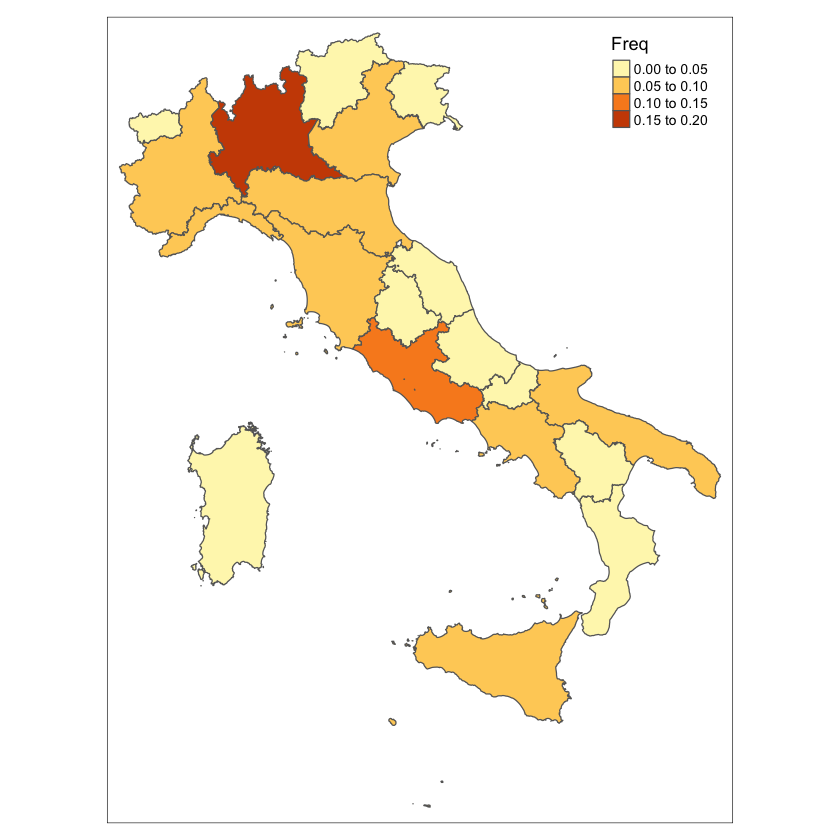

In [78]:
# Grafico con le frequenze relative per regione
#tmap_mode("view")
qtm(geo_regioni, "Freq")

In [79]:
# Tolgo la colonna con l'identificazione della zona 
drop <- c("COD_REG")
geo_regioni@data = geo_regioni@data[,!(names(geo_regioni@data) %in% drop)]

In [80]:
tm <- tm_shape(geo_regioni) +
    tm_polygons("Incidenti_per_100000_abitanti", legend.title = "Incidenti per 100'000 abitanti, 2017")

In [81]:
# Grafico con incidenti per 100'000 abitanti per regione
tmap_mode("plot")
tm <- tm_shape(geo_regioni) +
    tm_polygons("Incidenti_per_100000_abitanti", legend.title = "Incidenti per 100'000 abitanti, 2017")
tmap_save(tm, filename = "results/incidenti_per_100000_abitanti.png")
tmap_save(tm, filename = "incidenti_per_100000_abitanti.html")

tmap mode set to plotting
Warning message:
“The shape geo_regioni is invalid. See sf::st_is_valid”Warning message:
“The shape geo_regioni is invalid. See sf::st_is_valid”Map saved to /Users/leonardoalchieri/Desktop/GIT/car_accidents_italy/results/incidenti_per_100000_abitanti.png
Resolution: 1850.329 by 2383.359 pixels
Size: 6.167765 by 7.944531 inches (300 dpi)
Warning message:
“The shape geo_regioni is invalid. See sf::st_is_valid”Interactive map saved to /Users/leonardoalchieri/Desktop/GIT/car_accidents_italy/incidenti_per_100000_abitanti.html


Dopo aver calcolato gli incidenti per abitante nelle diverse regioni, siamo andati a ripetere i procedimento per il parco veicolare, ovvero per il numero di veicoli in ogni regione. A nostro parere, questo potrebbe risultare essere un incide migliore per valutare la pericolosità di una particolare regione.

In [82]:
dataset_pop$parco_veicolare = c(7850589,4868938,4420628,4344556,4002778,3789017,3777687,2917885,3381332,1592866,1328799,1337699,1364973,1143937,1028446,1226089,814635,468788,280453,215315)

In [83]:
for(i in 1:length(geo_regioni$Freq))
{
        geo_regioni$Incidenti_per_100000_veicoli[i] =  100000 * geo_regioni$Freq[i] * nrow(dataset_proj) /  dataset_pop$parco_veicolare[which(dataset_pop$Regione == geo_regioni$DEN_REG[i])]
}

In [84]:
# Grafico con incidenti per 100'000 abitanti per regione
tmap_mode("plot")
tm <- tm_shape(geo_regioni) +
    tm_polygons("Incidenti_per_100000_veicoli", legend.title = "Incidenti per 100'000 veicoli, 2017")
tmap_save(tm, filename = "results/incidenti_per_100000_veicoli.png")
tmap_save(tm, filename = "incidenti_per_100000_veicoli.html")

tmap mode set to plotting
Warning message:
“The shape geo_regioni is invalid. See sf::st_is_valid”Warning message:
“The shape geo_regioni is invalid. See sf::st_is_valid”Map saved to /Users/leonardoalchieri/Desktop/GIT/car_accidents_italy/results/incidenti_per_100000_veicoli.png
Resolution: 1850.329 by 2383.359 pixels
Size: 6.167765 by 7.944531 inches (300 dpi)
Warning message:
“The shape geo_regioni is invalid. See sf::st_is_valid”Interactive map saved to /Users/leonardoalchieri/Desktop/GIT/car_accidents_italy/incidenti_per_100000_veicoli.html


Warning message:
“The shape geo_regioni is invalid. See sf::st_is_valid”

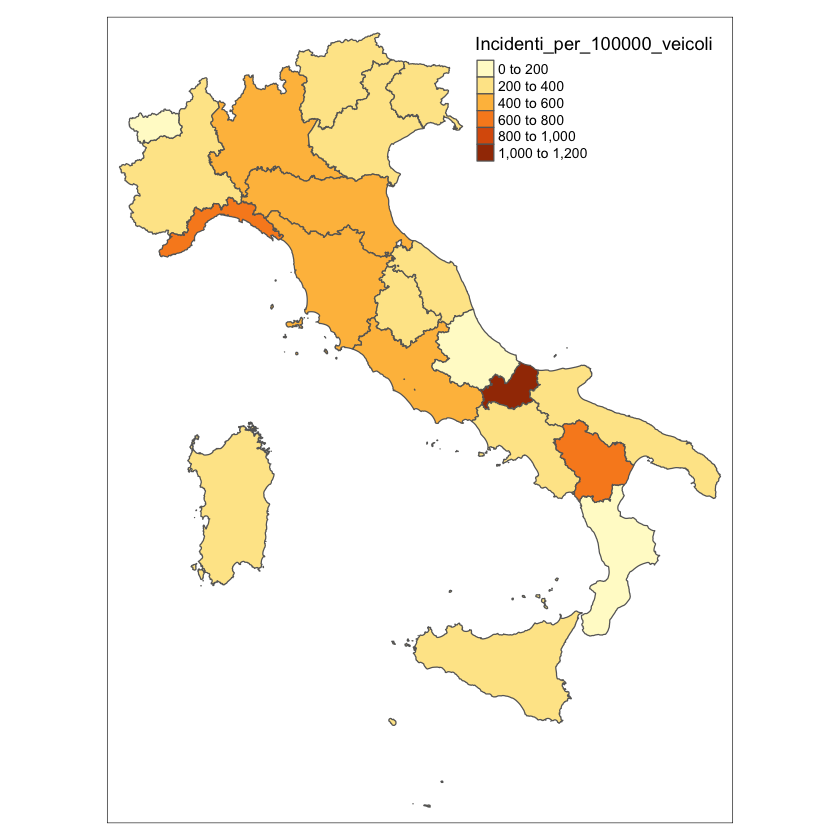

In [85]:
tm_shape(geo_regioni) +
    tm_polygons("Incidenti_per_100000_veicoli", legend.title = "Incidenti per 100'000 veicoli, 2017")

In entrambi i casi, si può notare come la regione che risalta sopra le altre è il Molise. Poiché incuriositi da questo fatto, siamo andati ad analizzare le differenze tra gli incidenti in Molise e nel resto di Italia, per magari capire se ci possa essere un fenomono unico della regione.

----
----

## Analisi Bivariata

### Confronto tra fondo stradale e tipo di strada

In questa sezione andiamo a vedere come il fondo stradale, ovvero se durante l'incidente esso fosse **asciutto**, **sdrucciolevole**, **bagnato**, **ghiacciato** o **innevato**, possa incidere in maniera diversa a seconda della localizzazione dell'incidente, ovvero se esso sia su **strada urbana**, **stada extraurbana** oppure **autostrada**.

Come si può vedere anche dai codici sopra, per prima cosa abbiamo raggruppato nei tre gruppi descritti qua sopra le varie classificazioni di `localizzazione incidente` come riportate nel dataset dall'ISTAT. 

Inizialmente, oltre alla distinzione tra *urbano*, *extraurbano* e *autostrada*, veniva fatta una distinzione anche in base all'ente responsabile di tale strada, ovvero *comune*, *provincia*, *regione* o *stato*. Poiché al fine della nostra analisi questo non portava alcun tipo di informazione, abbiamo raggrupatto nelle tre classi come descritte. 

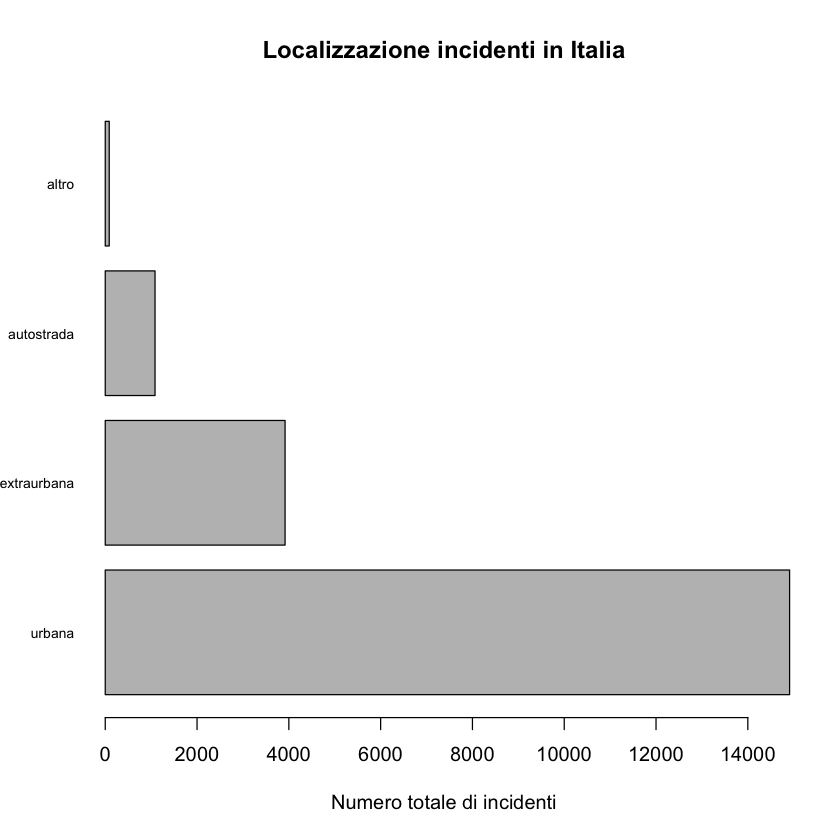

In [86]:
barplot(table(new_localizzazione_incidente),
        xlab='Numero totale di incidenti', 
        #ylab='Denominazione autostrada', 
        main='Localizzazione incidenti in Italia',
       horiz=TRUE,
        las=1, #per mettere le scritte sull'asse y in orizzontale
       cex.names=.7)

In [87]:
pdf("results/localizzazione_incidenti.pdf")
barplot(table(new_localizzazione_incidente),
        xlab='Numero totale di incidenti', 
        #ylab='Denominazione autostrada', 
        main='Localizzazione incidenti in Italia',
       horiz=TRUE,
        las=1, #per mettere le scritte sull'asse y in orizzontale
       cex.names=.7)
dev.off()

pdf 
  2

Come si può notare dal grafico, la maggior parte degli incidenti con feriti e/o morti sono localizzati in strade urbane. 

Siamo riusciti solamente a ritrovare, dal sito web del *Ministero dei Trasporti e delle Infrastrutture*, la lunghezza di tutte le strade Italiane (*urbane* e *extraurbane*) e autostrade Italiane.

In [88]:
# Questi sono i dati che ho trovato da wikipedia.
lunghezza_strade_Italiane = 837493
lunghezza_autostrade_Italiane = 6757

In [89]:
new_localizzazione_incidenti_corta = array('altro', length(new_localizzazione_incidente))
for(i in 1:length(new_localizzazione_incidente))
{

    if(new_localizzazione_incidente[i] == 'urbana' || new_localizzazione_incidente[i] == 'extraurbana')
    {
        new_localizzazione_incidenti_corta[i] = 'strada'

    }
    if(new_localizzazione_incidente[i] == 'autostrada')
    {
        new_localizzazione_incidenti_corta[i] = 'autostrada'
    }
    
}

In [90]:
vettore_lunghezza_localizzazione = c(lunghezza_strade_Italiane,lunghezza_autostrade_Italiane,lunghezza_strade_Italiane)

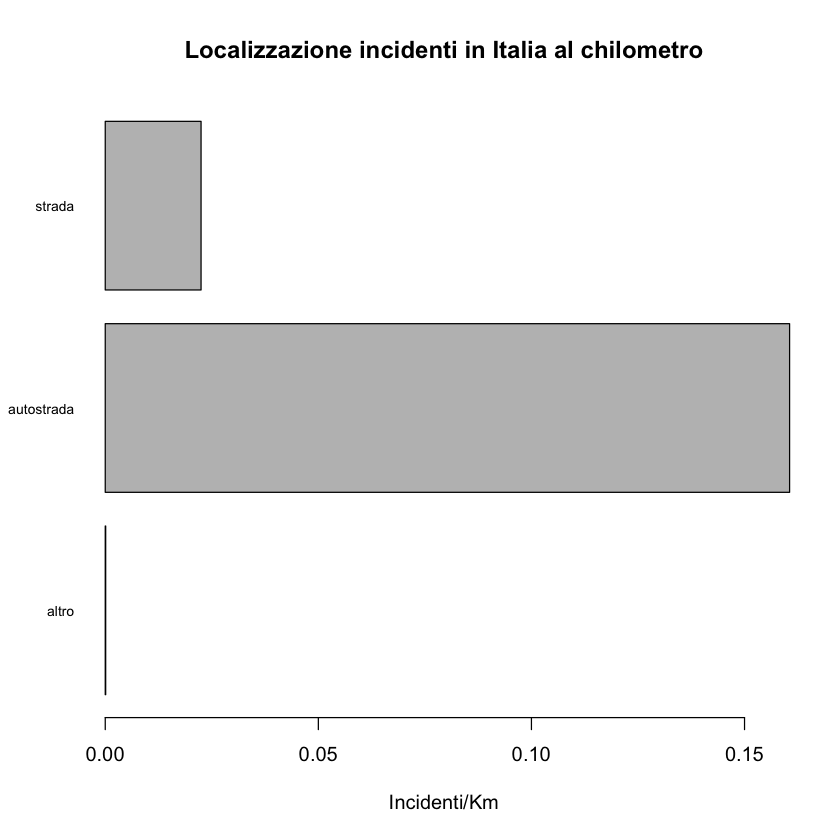

In [107]:
barplot(table(new_localizzazione_incidenti_corta) / vettore_lunghezza_localizzazione,
        xlab='Incidenti/Km', 
        #ylab='Denominazione autostrada', 
        main='Localizzazione incidenti in Italia al chilometro',
       horiz=TRUE,
        las=1, #per mettere le scritte sull'asse y in orizzontale
       cex.names=.7)

In [92]:
pdf("results/localizzazione_per_chilometro.pdf")
barplot(table(new_localizzazione_incidenti_corta) / vettore_lunghezza_localizzazione,
        xlab='Incidenti/Km', 
        #ylab='Denominazione autostrada', 
        main='Localizzazione incidenti in Italia per chilometro',
       horiz=TRUE,
        las=1, #per mettere le scritte sull'asse y in orizzontale
       cex.names=.7)
dev.off()

pdf 
  2

Come si può vedere, per chilometro di strada, le autostrade risultano più pericolose al chilometro. Un'analisi completa dovrebbe tenere in considerazione anche del traffico, ovvero del numero di automobili presenti. 

Non si può comunque dedurre completamente che le autostrade sono più pericolose rispetto alle strade urbano o extraurbane. Abbiamo solamente mostrato che, per chilometro di strada, si hanno molti più incidenti sulle autostrade. 

Successivamente siamo quindi andati a confrontare con i dati sulle condizioni del fondo stradale, come descritto sopra.

In [93]:
fondo_stradale <- factor(fondo_stradale)
levels(fondo_stradale) <- c("asciutto", "bagnato", "sdrucciolevole", "ghiacciato", "innevato")

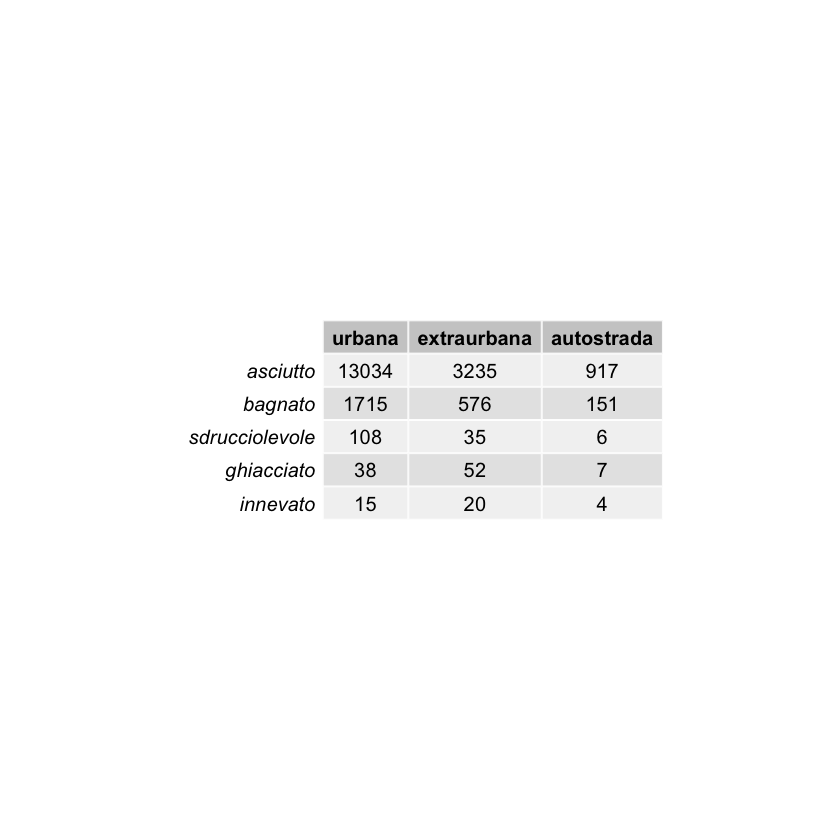

In [94]:
tabella_fondo_tipo_strada <- table(fondo_stradale, new_localizzazione_incidente)
# Rimuovo l'ultima colonna, che rende solamente poco leggibile il grafico
tabella_fondo_tipo_strada <- tabella_fondo_tipo_strada[,-4]
grid.table(tabella_fondo_tipo_strada)

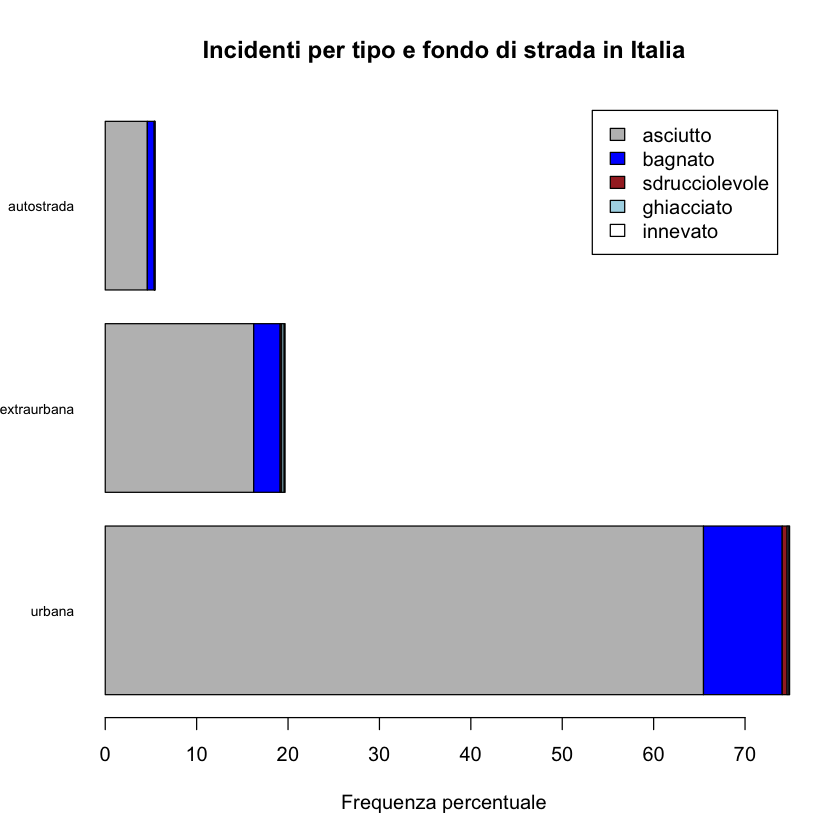

In [95]:
barplot(tabella_fondo_tipo_strada/sum(tabella_fondo_tipo_strada)*100,
       main="Incidenti per tipo e fondo di strada in Italia",
       horiz=TRUE,
       col=c("grey", "blue", "brown", "light blue", "white"),
        las=1, #per mettere le scritte sull'asse y in orizzontale
       legend = rownames(tabella_fondo_tipo_strada),
        xlab='Frequenza percentuale',
       cex.names=0.7)

In [96]:
pdf("results/localizzazione_fondo.pdf")
barplot(tabella_fondo_tipo_strada/sum(tabella_fondo_tipo_strada)*100,
       main="Incidenti per tipo e fondo di strada in Italia",
       horiz=TRUE,
       col=c("grey", "blue", "brown", "light blue", "white"),
        las=1, #per mettere le scritte sull'asse y in orizzontale
       legend = rownames(tabella_fondo_tipo_strada),
        xlab='Frequenza percentuale',
       cex.names=0.7)
dev.off()

pdf 
  2

In dettaglio, siamo andati a calcolare la probabilità che il terreno bagnato potesse avere influenza sul tipo di strada. 

In [97]:
tot_incidenti_urbani = sum(tabella_fondo_tipo_strada[,1])
tot_incidenti_extra_urbani = sum(tabella_fondo_tipo_strada[,2])
tot_incidenti_autostrada = sum(tabella_fondo_tipo_strada[,3])

In [98]:
prob_incidente = array(666, dim=c(nrow(tabella_fondo_tipo_strada), ncol(tabella_fondo_tipo_strada),3))

In [108]:
prob_incidente_per_acqua_urbano = tabella_fondo_tipo_strada[2]/tot_incidenti_urbani
cat("Probabilità incidente causato da fondo bagnato in strada urbana", as.integer(prob_incidente_per_acqua_urbano*10000)/100, "%\n")

Probabilità incidente causato da fondo bagnato in strada urbana 11.5 %


In [109]:
prob_incidente_per_acqua_extra_urbano = tabella_fondo_tipo_strada[2,2]/tot_incidenti_extra_urbani
cat("Probabilità incidente causato da fondo bagnato in strada extra urbana", as.integer(prob_incidente_per_acqua_extra_urbano*10000)/100, "%\n")

Probabilità incidente causato da fondo bagnato in strada extra urbana 14.7 %


In [110]:
prob_incidente_per_acqua_autostrada = tabella_fondo_tipo_strada[2,3]/tot_incidenti_autostrada
cat("Probabilità incidente causato da fondo bagnato in autostrada", as.integer(prob_incidente_per_acqua_autostrada*10000)/100, "%\n")

Probabilità incidente causato da fondo bagnato in autostrada 13.91 %


Una volta calcolate le probabilità associate ai 3 diversi tipi di strada, siamo andati a confrontarle al livello di significatività del 99%, ovvero col quale avremmo quasi l'assoluta certezza che vi sia una differenza di tipo statistico.

Per eseguire questo, devo calcolare:
$$
    Z = \frac{p_1 - p_2}{\sqrt{p(1-p)\cdot\left(\frac 1 {n_1} + \frac{1}{n_2}\right)}}
$$

In [102]:
test_indipendenza <- function(p1,p2,n1,n2)
    {
        # Per valutare p, faccio la media tra p1 e p2 pesata sulla rispettiva grandezza del campione, 
        # ovvero n₁ e n₂
        p = (p1*n1 + p2*n2)/(n1+n2)

        Z = abs(p1 - p2)/(sqrt(p*(1-p) *(1/n1 + 1/n2)))
        print(Z)
        if(Z > qnorm(0.995))
        {
            print('Con il confidence level dato, si ha che non esiste indipendenza dal fondo bagnato.')
        }else{
            print('Con il confidence level dato, vi è indipendenza tra i due tipi di strada in caso di fondo bagnato.')
        }
    }

In [103]:
# Verifico l'ipotesi che non ci sia differenza tra strada urbana e extraurbana. 
# Ovvero, la mia H₀ è che p₁ - p₂ = 0, 
# dove p₁ è riferito a strada urbana e p₂ a extraurbana.

test_indipendenza(prob_incidente_per_acqua_urbano,
                 prob_incidente_per_acqua_extra_urbano,
                 tabella_fondo_tipo_strada[2],
                 tabella_fondo_tipo_strada[2,2])

[1] 2.022069
[1] "Con il confidence level dato, vi è indipendenza tra i due tipi di strada in caso di fondo bagnato."


Dal risultato precedente si deduce che, come teorizzato, si ha dipendenza nell'effetto del fondo bagnato a seconda che l'incidente sia localizzato in una strada urbana o in una extraurbana. 

Ovvero, se vi è fondo bagnato, in una starda extraurbana si ha probabilità maggiore che accada un incidente.

Si ripete di seguito lo stesso calcolo confrontando strada urbana e autostrada con fondo bagnato.

In [104]:
# Verifico l'ipotesi che non ci sia differenza tra strada urbana e autostrada 
# Ovvero, la mia H₀ è che p₁ - p₂ = 0, 
# dove p₁ è riferito a strada urbana e p₂ a extraurbana.
test_indipendenza(prob_incidente_per_acqua_urbano,
                 prob_incidente_per_acqua_autostrada,
                 tabella_fondo_tipo_strada[2],
                 tabella_fondo_tipo_strada[2,3])

[1] 0.8850982
[1] "Con il confidence level dato, vi è indipendenza tra i due tipi di strada in caso di fondo bagnato."


In questo caso, si è mostrato che tra *fondo bagnato in strada urbana* e *fondo bagnato in autostrada* vi è indipendenza, ovvero che l'acqua non rende l'autostrada più pericolosa rispetto a una strada urbana.

Eseguiamo lo stesso calcolo confrontando tra strada extraurbana e autostrada, aspettandoci che vi sia indipendenza tra i due. 

In [105]:
# Verifico l'ipotesi che non ci sia differenza tra strada urbana e autostrada 
# Ovvero, la mia H₀ è che p₁ - p₂ = 0, 
# dove p₁ è riferito ad autostrada e p₂ ad autostrada.

test_indipendenza(prob_incidente_per_acqua_extra_urbano,
                 prob_incidente_per_acqua_autostrada,
                 tabella_fondo_tipo_strada[2,2],
                 tabella_fondo_tipo_strada[2,3])

[1] 0.2433802
[1] "Con il confidence level dato, vi è indipendenza tra i due tipi di strada in caso di fondo bagnato."


Come da atteso, non vi è differenza statistica tra strada extraurbana e autostrada in presenza di fondo bagnato.

Quello che abbiamo trovato significa che vi è un significativa differenza statistica tra la presenza di fondo bagnato in strada urbana o extra-urbana. 

Lo stesso non si può dire per gli altri due casi analizzati, ovvero statisticamente il fondo bagnato non provoca differenza tra autostrada e gli altri due tipi di strada. Il motivo di questa può essere ricercato nella minore grandezza del campione di incidenti in autostrada.

-----
